In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# Bayesian Analysis with Python
By Osvaldo Martin

## Contents
1. Thinking Probablistically: basic concepts of Bayes
2. Programming Probablistically: Intros pyMC3 and Arviz
3. Linear regression
4. Generalising linear models
5. Model comparison: compare select and average models, WAIC, LOO and Bayes factor
6. Mixture models: add flexibility by mixing similar distributions to create complex ones. Intro to non-parametric models with Dirichlet process
7. Gaussian processes
8. Inference engines: methods for numerically approximating posteriors, diagnosing reliabiity of posterior
9. where next?

# Chapter 1: Thinking Probablistically

## Statistical Modelling

### Statistical Methods
There are two in data analysis:
* Exploratory Data Analysis (EDA): Numerical summaries of data (descriptive statistics) and visual inspection (graphing)
* Inferential statistics: Making statements beyong current data, predictions, explaining observations

Here we focus on IS methods, then using EDA to summarise, interpret, check, communicate results 

### Data
Generating data is a __stochastic process__, there is uncertainty involved, because of limitations of measurement precision. With technical sampling this can be technical, i.e. our machines/measurements generate noise or can't measure precisely.

### Bayesian modelling
Three steps:
1. design our crude model by combining __probability distributions__ like building blocks
2. Use Bayes' theorem to add data and generate the outcome (called _conditioning the model on data_)
3. Critisise the model by checking it. 

## Probability and Uncertainty
### Interpreting probailities
A __probability__ is a measure that quantifies the uncertainty of a statement, in the interval \[0,1\]. 

In a Bayesian framework it is a relative/subjective concept, it depends on what WE know. 'What is the probability there is life on Mars?' is a valid question in Bayes, as opposed to an 'objective' framework, which would say the probability that there is life on Mars is either 1 or 0 because there either is or there isn't.

Probablity is an extention of logic. Where logic is the science of the certain, things are either true or false, these conditions are a special case of probability; true and false are equivalent to the probability of something being 1 or 0 respectively, and probability also includes everything in-between these two extremes. __Cromwell's rule__ states that you should limit the assignation of probabilities of 1 or 0 to logically True or False statements.

(There is an assymetry here: it is easier to show the probablity of something is 1 than 0. You can't prove a negative.)

### Defining probabilities - mathematical properties
#### The Product Rule
$$p(A,B) = p(A \mid B)p(B)$$

$p(A,B)$ is the joint probability.

$p(A \mid B)$ is the conditional probability.

### Probability Distributions
An object that describes how likely different events are, with events restricted to a set of possible events in the sample space.

A common conceptualisation: Data is generated from some _true_ probability distribution with unknown parameters. __Inference__ is the process of trying to figure out that true probability distribution and its parameters from a sample (the _Dataset_), by creating and improving a model approximating the true probability distribution.

If a variable $X$ can be described using a PD, we call $X$ a __random variable__.

$x$ would indicate an instance of that random variable. It can be a vector and contain many values, $x = (x_1, x_2, \dots , x_n)$.

Using Python's scipy.stats package we can define a random variable $X$ by specifying its distribution, then get an instance $x$ by sampling random variates (`rvs`) from it. Each time we sample we will get a different, random, result, because the sampling is a stochastic process. How likely we are to get a particular value for $x$ is determined by the probability distribution.

In [2]:
μ = 0
σ = 1
X = stats.norm(μ, σ)
x = X.rvs(3)
x

array([ 0.70819091, -0.55770499,  0.43272628])

The concept of inference is that if we generate random variates enough times, we can build up a picture of how likely each result is, and infer the true probability distribution of $X$

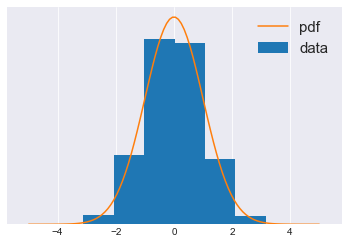

In [3]:
x = X.rvs(1000000)
x1 = np.linspace(-5,5,100)

plt.hist(x, label='data')
plt.yticks([])
plt.plot(x1, X.pdf(x1)*1000000, label='pdf')
plt.legend(fontsize = 15)
plt.show()

You denote that a variable is distributed normally with parameters $\mu,\sigma$ as follows:

$$X \sim N(\mu,\sigma)$$

A saying something is normally distributed is equivalent to saying that the probability of randomly selecting a value of $x$ is dictated by the formula:

$$p(x \mid \mu, \sigma) = \frac{1}{\sigma \sqrt{2\pi}}e^{-\frac{\left(x-\mu\right)^2}{2\sigma^2}}$$

This is called the __probability density function__, pdf, and each type of distribution is defined by one of these. (the equivalent for a discrete distribution is the probability mass function, or pmf)

Let's explore the pdfs of Normal distributions with different parameters visually

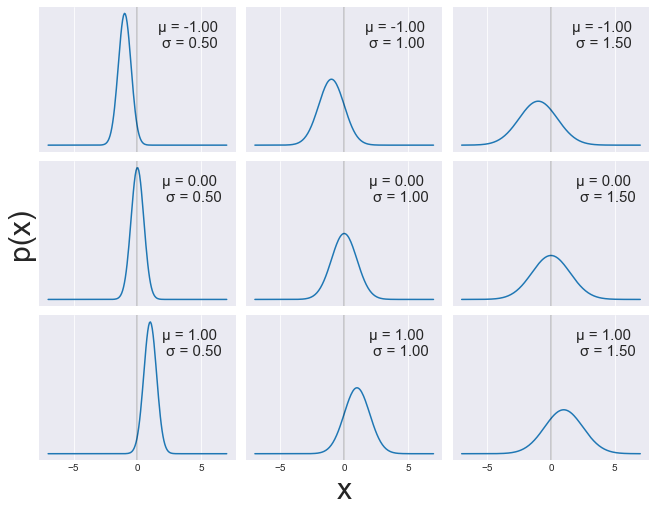

In [4]:
μ_params = [-1,0,1]
σ_params = [0.5,1,1.5]
x = np.linspace(-7,7,200)
_, ax = plt.subplots(len(μ_params), len(σ_params), 
                    sharex=True, sharey=True,
                    figsize=(9,7), constrained_layout=True)

for i in range(3):
    for j in range(3):
        μ = μ_params[i]
        σ = σ_params[j]
        y = stats.norm(μ, σ).pdf(x)
        ax[i,j].plot(x,y)
        ax[i,j].plot([], label="μ = {:3.2f} \n σ = {:3.2f}".format(μ,σ), alpha=0)
        ax[i,j].legend(loc=1, fontsize=15)
        ax[i,j].axvline(0, color='black', alpha = .2)
ax[2,1].set_xlabel('x', fontsize=30)
ax[1,0].set_ylabel('p(x)', fontsize=30)
ax[1,0].set_yticks([])

plt.show()

## Bayes theorem and statistical inference

## Single parameter inference (the coin flip problem)
To summarise where we are

> Probabilities are used to measure the uncertainty we have about parameters, and Bayes' theorem is the mechanism to correctly update those probabilities in light of new data, hopefully reducing our uncertainty.

Lets do a simple worked example: flipping a coin

### Conceptualising the model
Our situation is that we have a coin and we want to determine whether it is fair. Or more specifically we want to infer from data what the (currently unknown) probability is that the coin will land heads.

To represent this probability we assign it a random variable $\theta$. So we will need to define a probability distribution for $\theta$. 

We will represent as $Y$ the random variable of the number of heads obtained from N tosses of the coin.

### Choosing the likelihood
The classic choice for representing coin tossing is the Binomial distribution. 

A couple of assumptions are implicit in this distribution: Two outcomes are possible, heads or tails, and all tosses are independent of any other.

$$Y \sim Bin(N, \theta)$$

$$p(y \mid \theta, N) = \frac{N!}{y!(N-y)!}\theta^y(1-\theta)^{N-y}$$

Lets get the shape of this distribution by using the pmf for a few fixed values of N and $\theta$

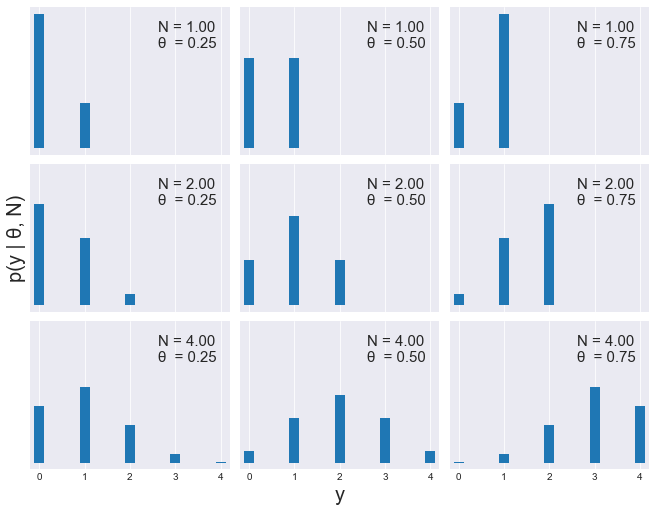

In [5]:
N_params = [1,2,4]
θ_params = [0.25,0.5,0.75]

x = np.arange(0, max(N_params)+1)
fig,ax = plt.subplots(len(N_params), len(θ_params),
                     sharex = True, sharey = True,
                     figsize=(9,7), constrained_layout=True)

for i in range(len(N_params)):
    for j in range(len(θ_params)):
        N = N_params[i]
        θ = θ_params[j]
        
        y = stats.binom(n=N, p=θ).pmf(x)
        
        ax[i,j].vlines(x, 0, y, lw=10, color = 'C0') # syntax here is vline(x, ymin, ymax)
        ax[i,j].plot([], label="N = {:3.2f}\nθ  = {:3.2f}".format(N,θ), alpha=0)
        ax[i,j].legend(fontsize=15)
        
ax[2,1].set_xlabel('y', fontsize=20)
ax[1,0].set_ylabel('p(y | θ, N)', fontsize=20)
ax[0,0].set_xticks(x)
ax[0,0].set_yticks([])
plt.show()

### Choosing the prior
We're going to choose an instance of the __beta__ distribution, with picked $\alpha$ and $\beta$, as our prior.

The Beta is defined by the pdf

$$p(\theta) = \frac{\Gamma\left(\alpha+\beta\right)}{\Gamma\left(\alpha\right)\Gamma\left(\beta\right)} \theta^{\alpha-1} (1-\theta)^{\beta-1}$$

Again lets explore this graphically.

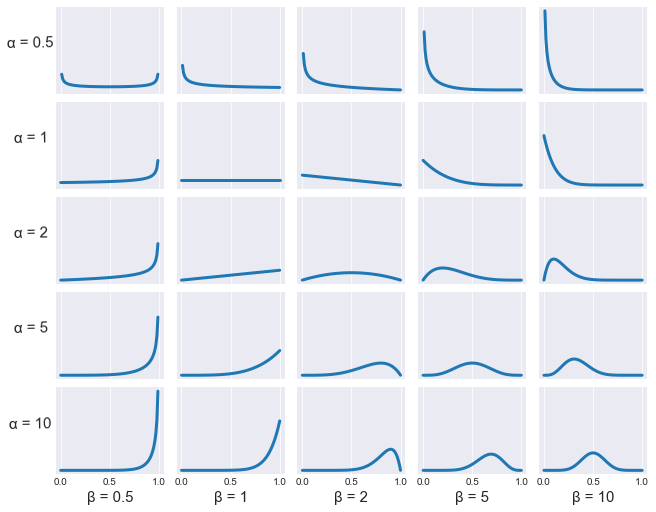

In [6]:
params = [0.5,1,2,5,10]
x = np.linspace(0,1,100)
fig, ax = plt.subplots(len(params), len(params),
                      sharex=True, sharey=True,
                      figsize=(9,7), constrained_layout=True)

for i in range(5):
    for j in range(5):
        α = params[i]
        β = params[j]
        y = stats.beta(α, β).pdf(x)
        
        ax[i,j].plot(x,y, lw=3, color='C0')
        ax[i,0].set_ylabel('α = '+str(params[i]), fontsize=15, rotation=1, labelpad=25)
        ax[4,j].set_xlabel('β = '+str(params[j]), fontsize=15)
        
ax[0,0].set_yticks([])
ax[0,0].set_xticks([0,0.5,1])
plt.show()

Beta is a very versatile distribution. It can take a lot of shapes, including the u-like, uniforms, normal-ish. It is restricted to / valid for inputs between 1 and 0.

The Beta is the conjugate prior for the binomial, meaning our posterior will also be a Beta. This is important when assessing analytically, when only a few combinations of distributions are easily computable, but less important when we get to computing numerically (a major advantage of the new approach).

### Computing and plotting the posterior
Specifically when you combine a Beta and Binomial as we have, you get a posterior

$$\theta \mid y \sim \text{Beta}\left(\alpha_{prior}+y, \beta_{prior}+N-y\right)$$ 

lets plot the posterior under three possible priors parameterised with ($\alpha$, $\beta$), (1,1), (10,10), (1,5), and with 0 trials (i.e. the pure prior), and 1,2,3,4,8,16,32,50 and 100 trials.

Let's set the 'true' theta to 0.35, i.e. the coin is tails biased - we wouldn't know that in real life obviously

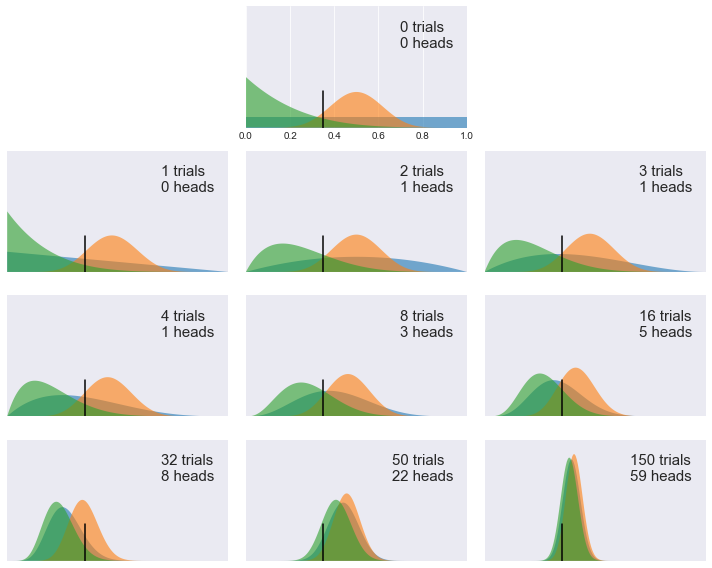

In [7]:
true_θ = 0.35
Beta_params = [(1,1),(10,10),(1,5)]
N_params = [0,1,2,3,4,8,16,32,50,150]
y_data = []
for N in N_params: 
    y_data.append(stats.binom(p=true_θ, n=N).rvs())

x = np.linspace(0.0,1.0,200)

plt.figure(figsize=(10,8))
for idx, N in enumerate(N_params):
    if idx == 0:
        plt.subplot(4,3,2)
    else:
        plt.subplot(4,3,idx+3)
        plt.xticks([])
    y = y_data[idx]
    for α, β in Beta_params:
        θ = stats.beta(a = α + y, b = β + N - y)
        plt.fill_between(x, θ.pdf(x), alpha = 0.6)
    plt.axvline(true_θ, ymax=0.3, color='k')
    plt.xlim(0,1)
    plt.ylim(0,12)
    plt.yticks([])
    plt.plot([], label='%d trials\n%d heads'%(N, y), alpha=0)
    plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

## Priors: Choosing them and why you should like them

## Communicating a Bayesian analysis